# FIT5149 S2 2020 
# Assessment 1: Predict the Electric Motor Rotor Temperature


Student information
- Family Name: Singh
- Given Name: Manmeet
- Student ID: 30749476
- Student email: msin0034@student.monash.edu

Programming Language: R 4.0.0 in Jupyter Notebook

R Libraries used:
- dplyr
- glmnet
- randomForest
- psych
- ggplot2
- reshape2
- gridExtra
- car
- e1071

## Table of Contents

1. [Introduction](#sec_1)
3. [Exploratory Data Analysis](#sec_3)
3. [Methodology](#sec_4)
3. [Model Development](#sec_5)
3. [Results and discussion](#sec_6)
3. [Conclusion](#sec_7)
3. [References](#sec_8)

## 1. Introduction <a class="anchor" id="sec_1"></a>

The findings of a data analysis conducted on a set of electric motor temperature collected from a permanent magnet synchronous motor (PMSM) are included in this notebook. Our aim here is to create a supervised model (Linear Regression and Random Forest) through data analysis from electric motor temperature data that can predict rotor temperature.

We will start with the EDA of data to explore and making inference from it. It examines the existence and distribution of attribute values for each attribute (variable) in the data. It also uses visual analysis to look at the association between the variables. The EDA's main results are highlighted in a review at the end.

A linear regression model can be seen in the second section. It explains how the model was created and displays the model at various stages in the creation process. Data is split into training and testing data based on the profile_id attribute. 

PMsm_temperature_data_A1_2021.csv was the only dataset issued for the assignment. The training_data dataframe was used for exploratory data analysis and model building, while the testing_data dataframe was only used to test the created model.

#### Prediction
We'll use the first 9 columns to estimate the last column region for our prediction mission. To do so, we'll divide the data into two sets, a training dataset and a testing dataset until modelling it. Then we'll fit the two models defined earlier to the training data, see how well they do on the testing data, and evaluate the model using performance metrics (like p-value). We will create two models to compare to complete this task. We will end by analysing our findings and justifying the best model.

#### Description
We would describe the main reasons that have a significant impact on the rotor temperature. We will also focus on the attributes that have the greatest impact on our model's efficiency. Variable correlation and interaction, regression, and some statistical analysis may be used to investigate this (such as F-statistic, Adjusted R Square, and p-values). We'll analyse the data to see if those characteristics have different effects on the forecast.

In [1]:
# Load the libraries used in the notebook
library(dplyr)
library(randomForest)
library(glmnet)
library(psych)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(car)
library(e1071)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'psych' was built under R version 3.6.3"
Attaching package: 'psych'

The following object is masked from 'package:randomForest':

    outlier

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

The following object is masked from 'package:randomForest':

    margin

Warning message:
"package 'reshape2' was built under R ver

In [2]:
# Reading the data
mydata <- read.csv("pmsm_temperature_data_A1_2021.csv")

#### Splitting data in training and testing dataset <a class="anchor" id="sec_13"></a>

We are going to use this data in following section: [Methodology](#sec_4)

In [3]:
# dropping 3 columns "stator_yoke", "stator_tooth", and "stator_winding" as they are not required for the analysis or prediction
rotor_temp <- subset(mydata, select = -c(stator_yoke, stator_tooth, stator_winding))

# Splitting the data into training and testing, we need data for testing where profile_id is 72 and 81

# training data
training_data <- filter(rotor_temp, profile_id != 72 & profile_id != 81)

# dropping profile_id column as it's not required for the analysis
training_data <- subset(training_data, select = -c(profile_id))

# testing data
testing_data <- filter(rotor_temp, profile_id == 72 | profile_id == 81)

# dropping profile_id column as it's not required for the analysis
testing_data <- subset(testing_data, select = -c(profile_id))

rotor_temp <- subset(rotor_temp, select = -c(profile_id))

#### Overview of the Dataset

In [4]:
# Dimensions of data
cat("The pmsp temperature dataset has", dim(rotor_temp)[1], "records, each with", dim(rotor_temp)[2],
    "attributes. The structure is:\n\n")

# Structure of data
str(rotor_temp)

cat("\nThe head and tail records of dataset are:")
# first few records
head(rotor_temp)
# last few records
tail(rotor_temp)

cat("\nBasic statistics for each attribute are:")
# Statistical summary 
summary(rotor_temp)

cat("The numbers of unique values for each attribute are:")
apply(rotor_temp, 2, function(x) length(unique(x)))

The pmsp temperature dataset has 15147 records, each with 9 attributes. The structure is:

'data.frame':	15147 obs. of  9 variables:
 $ ambient    : num  0.118 -0.555 -0.772 0.22 0.402 ...
 $ coolant    : num  -1.04 -1.09 -1.06 -1.08 -1.08 ...
 $ u_d        : num  -1.027 -1.226 0.299 -1.026 0.316 ...
 $ u_q        : num  0.925 0.513 0.956 0.928 -0.709 ...
 $ motor_speed: num  1.212 2.024 -0.14 1.212 -0.952 ...
 $ torque     : num  0.359 0.284 -0.259 0.357 -0.256 ...
 $ i_d        : num  -0.834 -1.364 1.029 -0.838 1.029 ...
 $ i_q        : num  0.323 0.234 -0.246 0.323 -0.246 ...
 $ pm         : num  -0.0883 0.7104 -1.5926 -0.1417 -1.9649 ...

The head and tail records of dataset are:

ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
0.1176819,-1.040829,-1.0267303,0.9250645,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267
-0.5547717,-1.087189,-1.2258921,0.5125759,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170
-0.7722329,-1.063652,0.2988575,0.9562448,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400
0.2199584,-1.083475,-1.0261079,0.9278145,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030
0.4015749,-1.078981,0.3155328,-0.7094008,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810
-0.7697667,-1.089577,0.2999456,0.9589649,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
15142,-0.6974700,1.49688820,0.3176318,-1.324828,-1.22242870,-0.2556397,1.0291415,-0.2457166,-0.835639600
15143,-0.1489317,1.74755540,0.2998942,-1.294876,-1.22242950,-0.2556397,1.0291376,-0.2457070,-0.993255400
15144,-0.5091294,1.46453430,-0.7905264,1.208344,0.80467504,0.3245067,-0.2590534,0.3256622,-0.004079474
15145,-0.1557110,-0.04516133,0.3011341,-1.294293,-1.22243130,-0.2556397,1.0291479,-0.2457459,-0.771475800
15146,-0.1561356,-0.04458057,0.3000615,-1.293905,-1.22242890,-0.2556397,1.0291611,-0.2456962,-0.663378950
15147,-0.7672885,-0.30993983,0.3228580,1.125235,-0.03886923,-0.2813110,1.0211550,-0.2752085,-1.903265100



Basic statistics for each attribute are:

    ambient           coolant              u_d               u_q         
 Min.   :-3.3278   Min.   :-1.23704   Min.   :-1.6537   Min.   :-1.8146  
 1st Qu.:-0.5390   1st Qu.:-0.69087   1st Qu.:-0.4860   1st Qu.:-1.2683  
 Median :-0.1403   Median :-0.04497   Median : 0.3001   Median :-0.3806  
 Mean   :-0.1074   Mean   : 0.18125   Mean   : 0.1102   Mean   :-0.1910  
 3rd Qu.: 0.4981   3rd Qu.: 1.00946   3rd Qu.: 0.3503   3rd Qu.: 0.7410  
 Max.   : 2.7106   Max.   : 2.29464   Max.   : 2.2735   Max.   : 1.7702  
  motor_speed          torque              i_d               i_q          
 Min.   :-1.2224   Min.   :-3.31634   Min.   :-3.1764   Min.   :-3.30867  
 1st Qu.:-1.2224   1st Qu.:-0.25765   1st Qu.:-0.5524   1st Qu.:-0.24579  
 Median :-0.4318   Median :-0.25564   Median : 0.5874   Median :-0.24571  
 Mean   :-0.1913   Mean   :-0.08396   Mean   : 0.1775   Mean   :-0.08147  
 3rd Qu.: 0.6743   3rd Qu.: 0.35654   3rd Qu.: 1.0291   3rd Qu.: 0.34990  
 Max.   : 2.0241   Max.   : 3.01

The numbers of unique values for each attribute are:

ambient     coolant         u_d         u_q motor_speed      torque 
      14263       14513       15126       15100        9434        9788 
        i_d         i_q          pm 
      10484       12451       15139

## 2. Exploratory Data Analysis<a class="anchor" id="sec_3"></a>

Through data exploration, we hope to find following:
- Distribution of the data.
- Data imbalanced
- Any outliers and Null values

To understand above steps, we will use following graphs:
 
- Boxplots
- Histograms
- Density plots
- Correlation matrix
- Scatterplots

To understand the attributes in more detail we have taken descriptions from following page https://www.kaggle.com/wkirgsn/electric-motor-temperature:

- **ambient**: Ambient temperature as measured by a thermal sensor located closely to the stator.
- **coolant**: Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
- **u_d**: Voltage d-component
- **u_q**: Voltage q-component
- **motor_speed**: Motor speed
- **torque**: Torque induced by current.
- **i_d**: Current d-component
- **i_q**: Current q-component
- **pm**: Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.


#### Before performing visual analysis, let see if we can find something through non-visual EDA

In [5]:
# Check for any null values in data set column wise.
for (cols in colnames(rotor_temp)) {
    print(paste("Null values in attribute", cols,"are",sum(is.na(rotor_temp$cols))))  
}

[1] "Null values in attribute ambient are 0"
[1] "Null values in attribute coolant are 0"
[1] "Null values in attribute u_d are 0"
[1] "Null values in attribute u_q are 0"
[1] "Null values in attribute motor_speed are 0"
[1] "Null values in attribute torque are 0"
[1] "Null values in attribute i_d are 0"
[1] "Null values in attribute i_q are 0"
[1] "Null values in attribute pm are 0"


There are no Null values or missing values present in the dataset. Let's see some statistics related to all the attributes. We have already covered the Basic statistics for each attribute in previous section. The range statistics (min, max, range) are most useful for data checking to detect coding errors.

In [6]:
# moving beyong basic statistics
round(describe(rotor_temp),3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ambient,1,15147,-0.107,0.833,-0.140,-0.062,0.721,-3.328,2.711,6.038,-0.648,1.806,0.007
coolant,2,15147,0.181,1.032,-0.045,0.111,1.179,-1.237,2.295,3.532,0.462,-1.073,0.008
u_d,3,15147,0.110,0.922,0.300,0.095,0.581,-1.654,2.273,3.927,0.018,-0.178,0.007
u_q,4,15147,-0.191,1.050,-0.381,-0.277,1.351,-1.815,1.770,3.585,0.419,-1.266,0.009
motor_speed,5,15147,-0.191,1.027,-0.432,-0.294,1.172,-1.222,2.024,3.247,0.538,-1.106,0.008
torque,6,15147,-0.084,0.917,-0.256,-0.093,0.489,-3.316,3.014,6.330,0.162,1.439,0.007
i_d,7,15147,0.177,0.969,0.587,0.316,0.655,-3.176,1.060,4.237,-0.835,-0.471,0.008
i_q,8,15147,-0.081,0.917,-0.246,-0.089,0.537,-3.309,2.914,6.223,0.123,1.441,0.007
pm,9,15147,-0.127,0.920,-0.121,-0.121,0.982,-2.605,2.905,5.510,-0.014,-0.238,0.007


We can observe following from above table:
- Attribute **ambient, and i_d** have negative skewness
- Attribute **coolant, and motor_speed** have positive skewness.
- Finally attributes **u_d, u_q, torque, and i_q** have very little skewness. All the observations here will be further visualised.
- kurtosis provides an indication of presence of outliers, we can identify potential outliers from the above observation attributes **ambient, torque, and i_q** have high positive kurtosis, so outliers might be present in the data, but through boxplot we can conclude if outlier exist or not.

### Let see the distribution of each attribute through BoxPlot

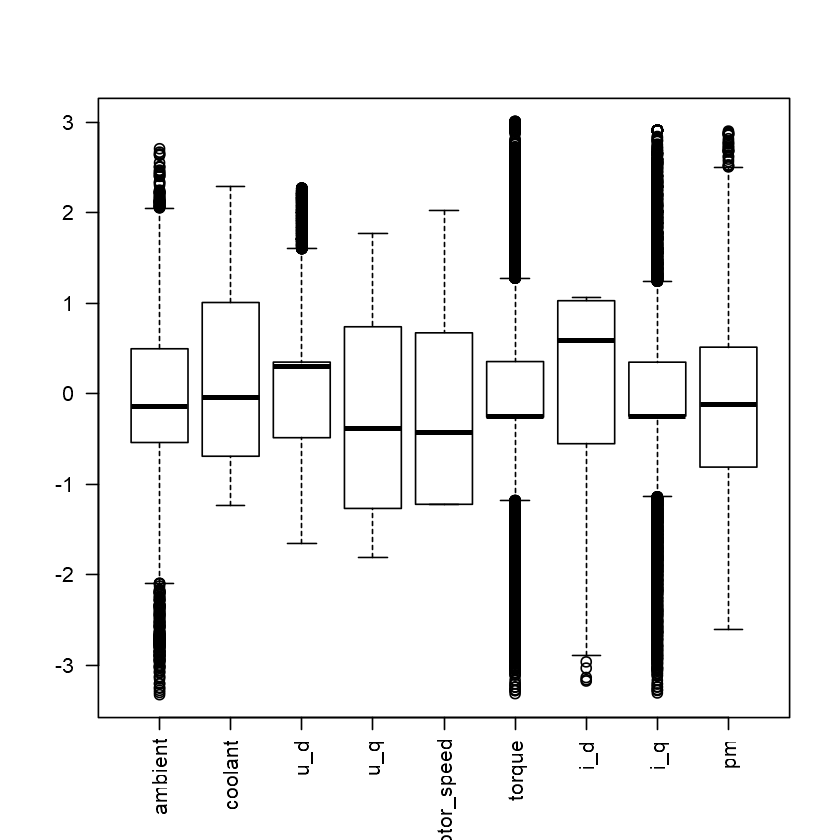

In [7]:
# Boxplot of dataset
boxplot(rotor_temp, las=2, cex.axis = 1)

No id variables; using all as measure variables


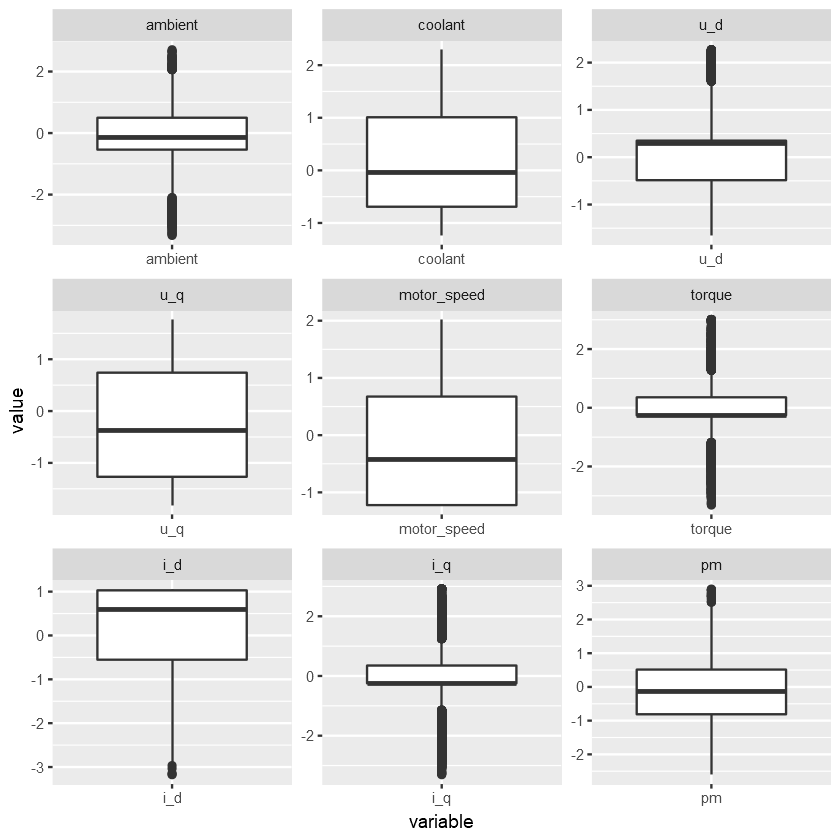

In [8]:
data <- melt(as.data.frame(rotor_temp))
ggplot(data,aes(x = variable,y = value)) + facet_wrap(~variable, scales="free") + geom_boxplot() +
scale_y_continuous(labels=function (n) {format(n, scientific=FALSE)})

From boxplot above we can confirm that attributes ambient, torque, and i_q do have outliers as they have data points beyond the limits and needs to be treated accordingly.

### Histograms and density plots

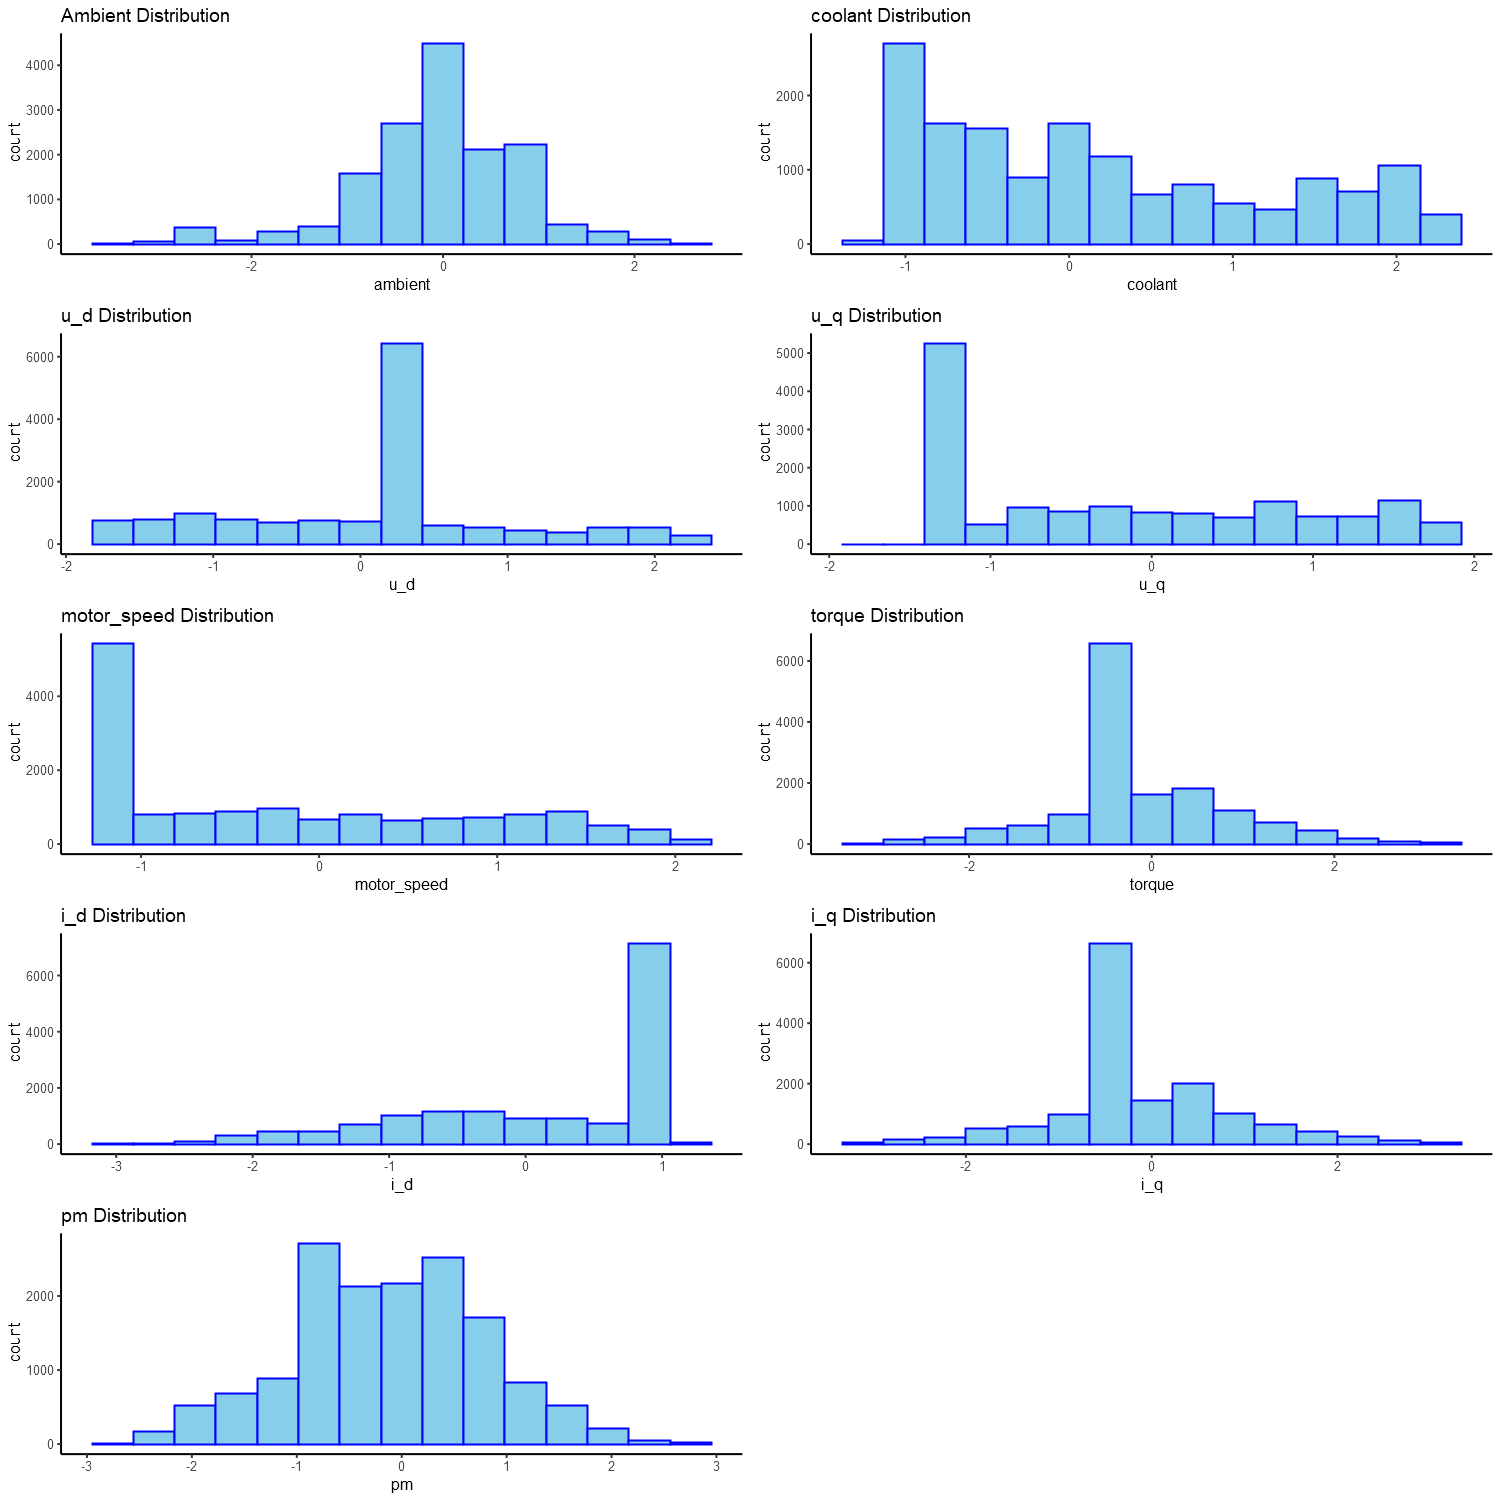

In [9]:
# Histogram plots
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 100)

ambient <- ggplot(rotor_temp, aes(x=ambient)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
ambient <- ambient + ggtitle("Ambient Distribution")

coolant <- ggplot(rotor_temp, aes(x=coolant)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
coolant <- coolant + ggtitle("coolant Distribution")

u_d <- ggplot(rotor_temp, aes(x=u_d)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
u_d <- u_d + ggtitle("u_d Distribution")

u_q <- ggplot(rotor_temp, aes(x=u_q)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
u_q <- u_q + ggtitle("u_q Distribution")

motor_speed <- ggplot(rotor_temp, aes(x=motor_speed)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
motor_speed <- motor_speed + ggtitle("motor_speed Distribution")

torque <- ggplot(rotor_temp, aes(x=torque)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
torque <- torque + ggtitle("torque Distribution")

i_d <- ggplot(rotor_temp, aes(x=i_d)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
i_d <- i_d + ggtitle("i_d Distribution")

i_q <- ggplot(rotor_temp, aes(x=i_q)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
i_q <- i_q + ggtitle("i_q Distribution")

pm <- ggplot(rotor_temp, aes(x=pm)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
pm <- pm + ggtitle("pm Distribution")

grid.arrange(ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm, ncol=2)

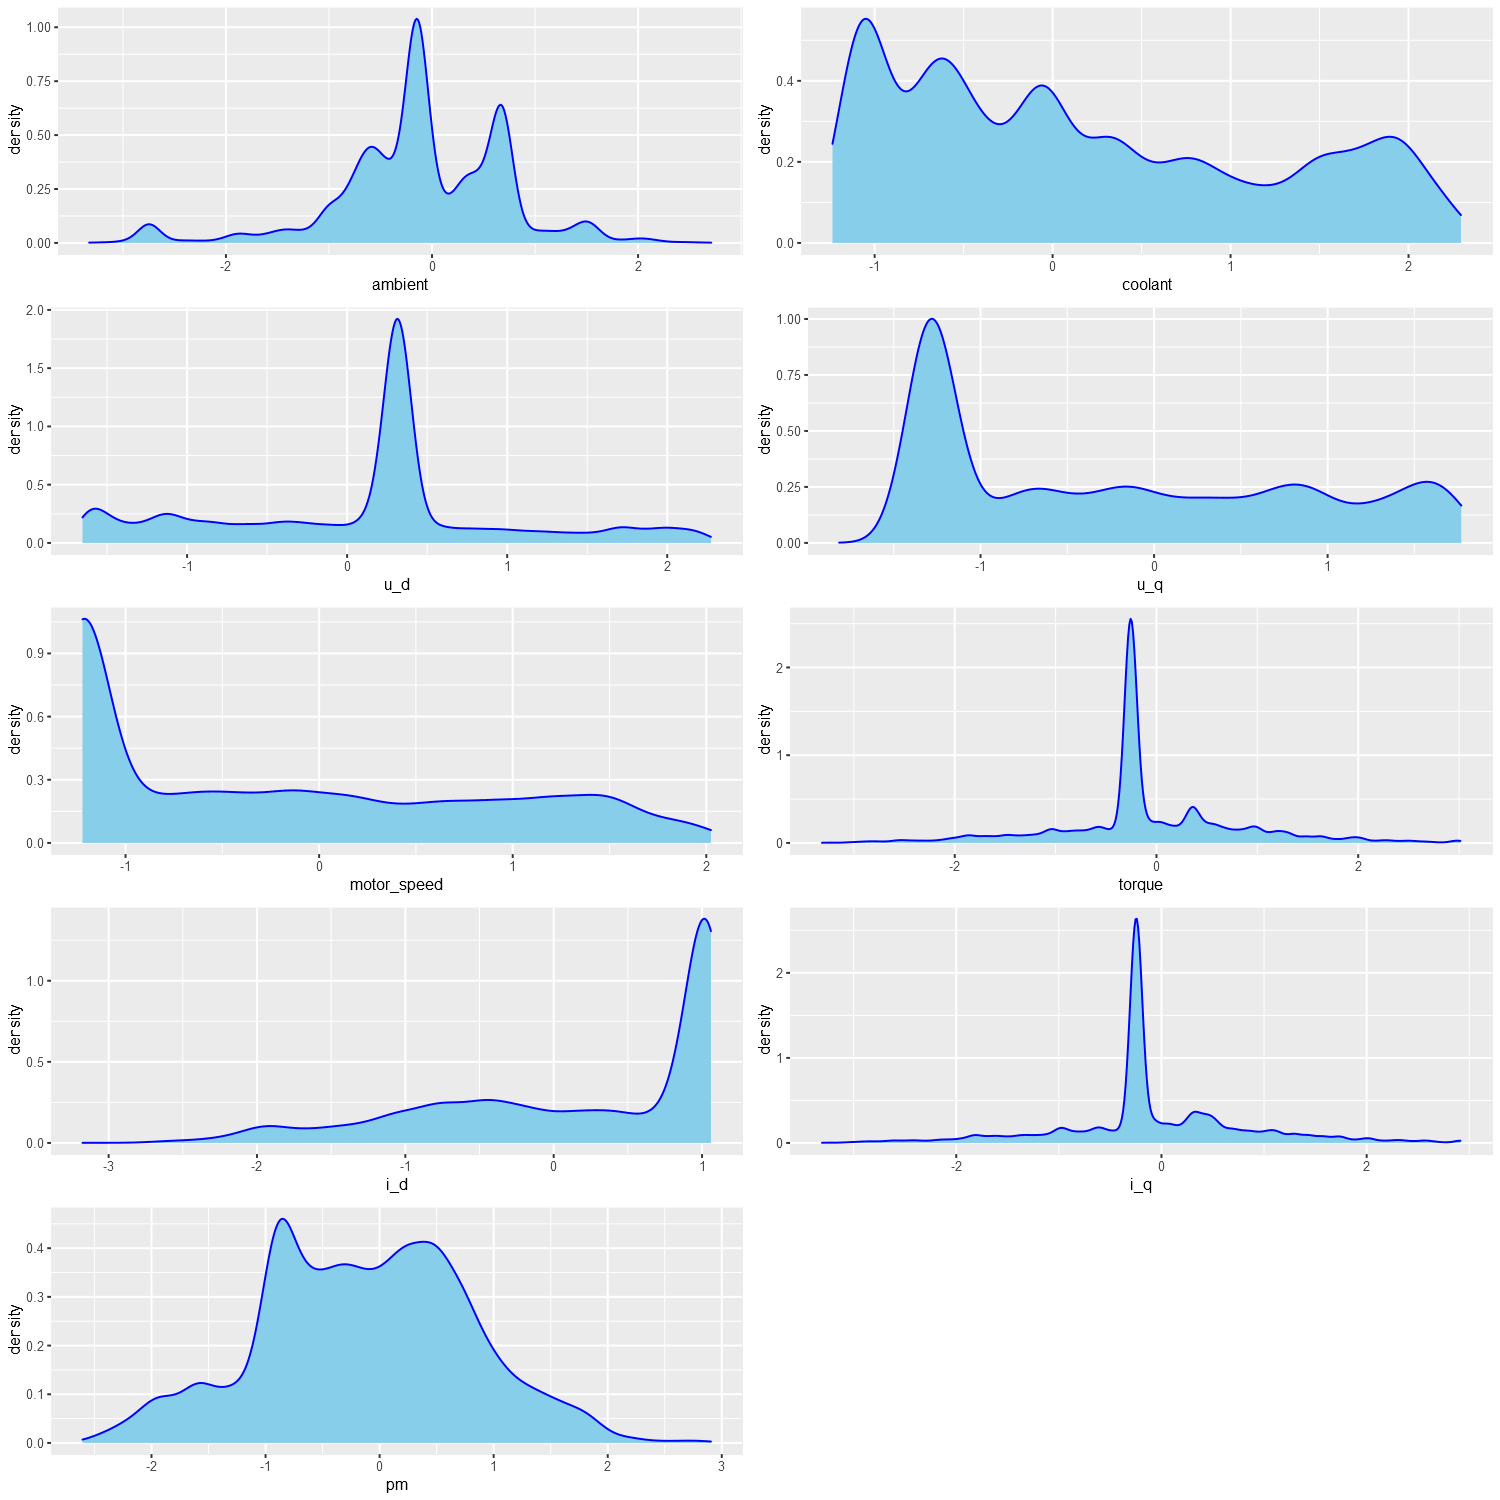

In [10]:
# Density plots
ambient<-ggplot(rotor_temp, aes(x=ambient)) + geom_density(colour = "blue", fill = "sky blue")
coolant<-ggplot(rotor_temp, aes(x=coolant)) + geom_density(colour = "blue", fill = "sky blue")
u_d<-ggplot(rotor_temp, aes(x=u_d)) + geom_density(colour = "blue", fill = "sky blue")
u_q<-ggplot(rotor_temp, aes(x=u_q)) + geom_density(colour = "blue", fill = "sky blue")
motor_speed<-ggplot(rotor_temp, aes(x=motor_speed)) + geom_density(colour = "blue", fill = "sky blue")
torque<-ggplot(rotor_temp, aes(x=torque)) + geom_density(colour = "blue", fill = "sky blue")
i_d<-ggplot(rotor_temp, aes(x=i_d)) + geom_density(colour = "blue", fill = "sky blue")
i_q<-ggplot(rotor_temp, aes(x=i_q)) + geom_density(colour = "blue", fill = "sky blue")
pm<-ggplot(rotor_temp, aes(x=pm)) + geom_density(colour = "blue", fill = "sky blue")

grid.arrange(ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm, ncol=2)

Trends we can notice few things from histogram and density plots:

- attributes ambient, i_d have left skewness.
- Torque, and i_q are somewhat normally distributed but that's not the case.
- i_d, motor_speed, u_q, u_d, and coolant all have something in common, all have atleast one such value which has the highest number of counts, or is most frequent value than other values. Which makes it interesting when we explore the correlation amoung the atttributes and with respect to target variable.
- Target variable is normally distributed which is a good sign.

### Transformation of attributes

As we know, to make good prediction it's good to have a normally distributed input and output variables. In this case we have nice normally distributed output variable i.e. pm. But the input attributes are not normally distributed.

We will apply tranformation technique to convert them. By reploting the attributes coolant, motor_speed using a log scale or square root we will try to find if they are distributed normally or not.



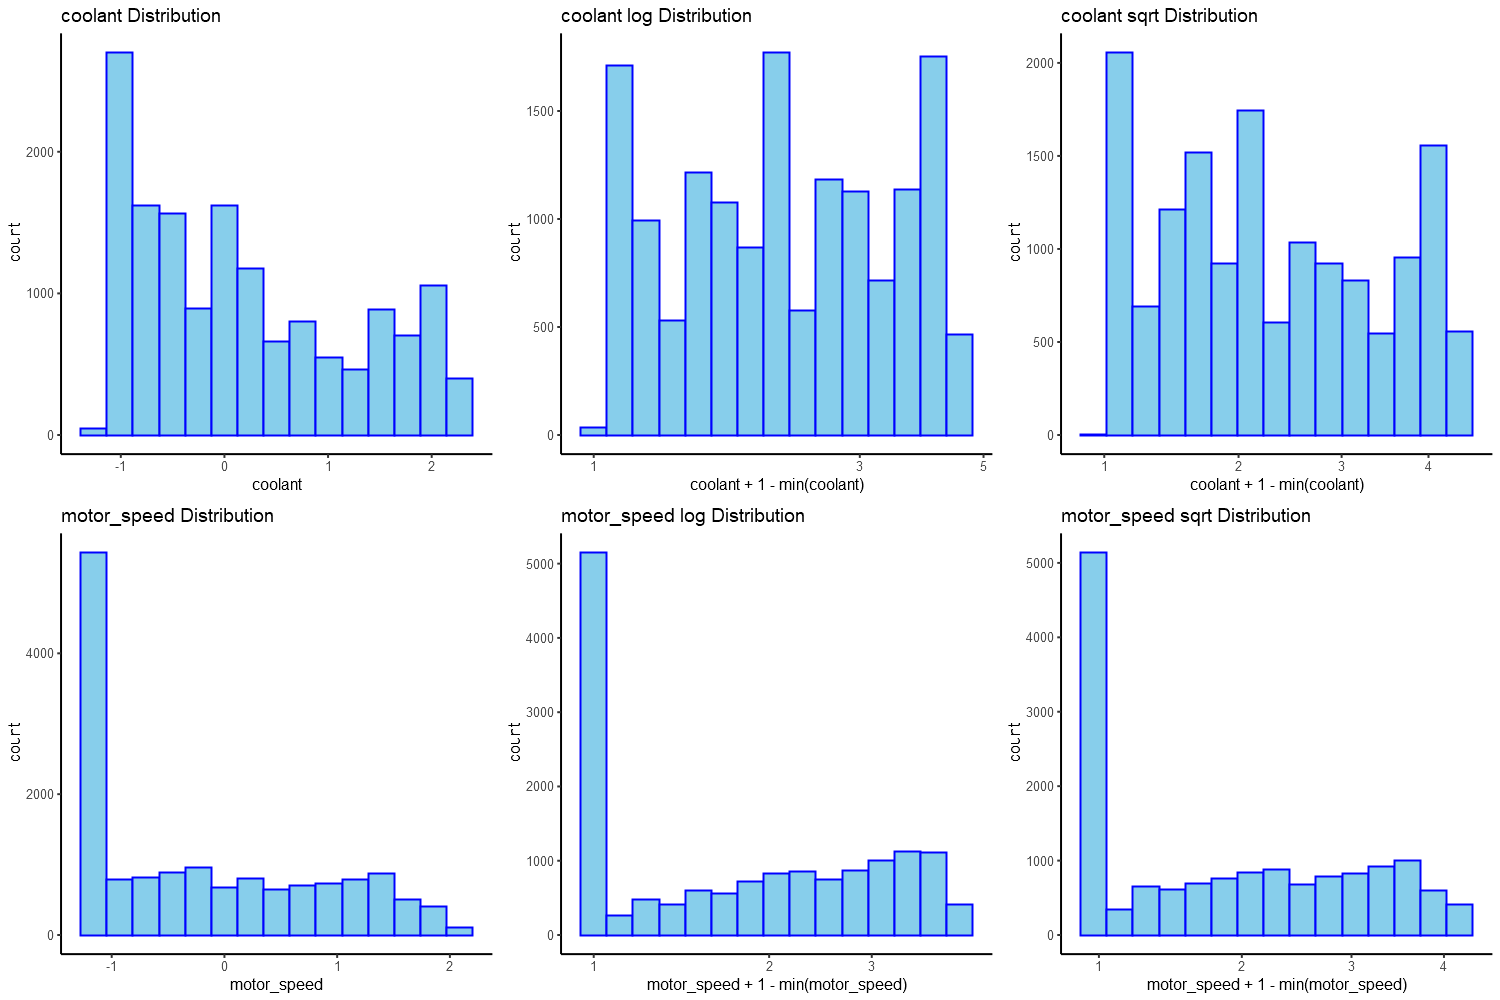

In [11]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

coolant <- ggplot(rotor_temp, aes(x=coolant)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
coolant <- coolant + ggtitle("coolant Distribution")

coolant.log <- ggplot(rotor_temp, aes(x=coolant+1-min(coolant))) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic() + scale_x_log10()
coolant.log <- coolant.log + ggtitle("coolant log Distribution")

coolant.sqrt <- ggplot(rotor_temp, aes(x=coolant+1-min(coolant))) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic() + scale_x_sqrt()
coolant.sqrt <- coolant.sqrt + ggtitle("coolant sqrt Distribution")

motor_speed <- ggplot(rotor_temp, aes(x=motor_speed)) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic()
motor_speed <- motor_speed + ggtitle("motor_speed Distribution")

motor_speed.log <- ggplot(rotor_temp, aes(x=motor_speed+1-min(motor_speed))) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic() + scale_x_log10()
motor_speed.log <- motor_speed.log + ggtitle("motor_speed log Distribution")

motor_speed.sqrt <- ggplot(rotor_temp, aes(x=motor_speed+1-min(motor_speed))) + geom_histogram(colour = "blue", fill = "sky blue", bins=15) + theme_classic() + scale_x_sqrt()
motor_speed.sqrt <- motor_speed.sqrt + ggtitle("motor_speed sqrt Distribution")

grid.arrange(coolant, coolant.log, coolant.sqrt, motor_speed, motor_speed.log, motor_speed.sqrt, ncol=3)

We have following observation from above graphs:

- We cannot use log and sqrt transformation directly as we have negative values. For that we can add a value to avoid nan values while transforming, using method **attribute + 1 - min(attribute)**, where min(attribute) gives minimum value of that attribute.
- After log and sqrt transformation of coolant, we can see better ditribution, as there is not much skweness.
- Even after the log and sqrt transformation on

From above transformation we can see, after applying both log and sqrt transformation on coolant and motor_speed, it helps some what to normalise coolant but motor_speed.

### Correlation between attributes and Scatter Plot

#### Correlation Coefficients

In [12]:
options(digits=4)
cor(rotor_temp)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
ambient,1.00000,0.29806,0.14523,0.090443,0.09340,-0.216923,-0.02151,-0.215262,0.49579
coolant,0.29806,1.00000,0.15828,-0.040009,-0.06987,-0.161076,0.13281,-0.157715,0.33273
u_d,0.14523,0.15828,1.00000,-0.044241,-0.18795,-0.834603,0.31703,-0.811286,-0.08094
u_q,0.09044,-0.04001,-0.04424,1.000000,0.79804,-0.005299,-0.36226,0.001397,0.13218
motor_speed,0.09340,-0.06987,-0.18795,0.798042,1.00000,0.033811,-0.77070,0.019384,0.31229
torque,-0.21692,-0.16108,-0.83460,-0.005299,0.03381,1.000000,-0.22852,0.996858,-0.05482
i_d,-0.02151,0.13281,0.31703,-0.362259,-0.77070,-0.228519,1.00000,-0.200093,-0.28856
i_q,-0.21526,-0.15771,-0.81129,0.001397,0.01938,0.996858,-0.20009,1.000000,-0.06524
pm,0.49579,0.33273,-0.08094,0.132183,0.31229,-0.054821,-0.28856,-0.065236,1.00000


Above table contain correlation coefficient from -1 to +1. High value 1 or closer to 1 means positive or strong correlation respectively. Value close to 0 and less means no correlation or negative correlation.

Significant positive correlation we found from above table are between:

- torque and i_q (current q component)
- motor_speed and u_q (voltage q component)
- pm and ambient

Significant negative correlation:

- torque and u_d (voltage d component)
- motor_speed and i_d (current d component)
- i_q and u_d

One thing we can note here is that q component of both current and voltage has direct relation to torque and motor_speed but inverse in case of d component.


In [13]:
# DIY correlation plot
# http://stackoverflow.com/questions/31709982/how-to-plot-in-r-a-correlogram-on-top-of-a-correlation-matrix
# there's some truth to the quote that modern programming is often stitching together pieces from SO 

colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

panel.cor <- function(w, z, ...) {
    correlation <- cor(w, z)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## trick: "don't create a new plot" thing by following the
    ## advice here: http://www.r-bloggers.com/multiple-y-axis-in-a-r-plot/
    ## This allows
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
}


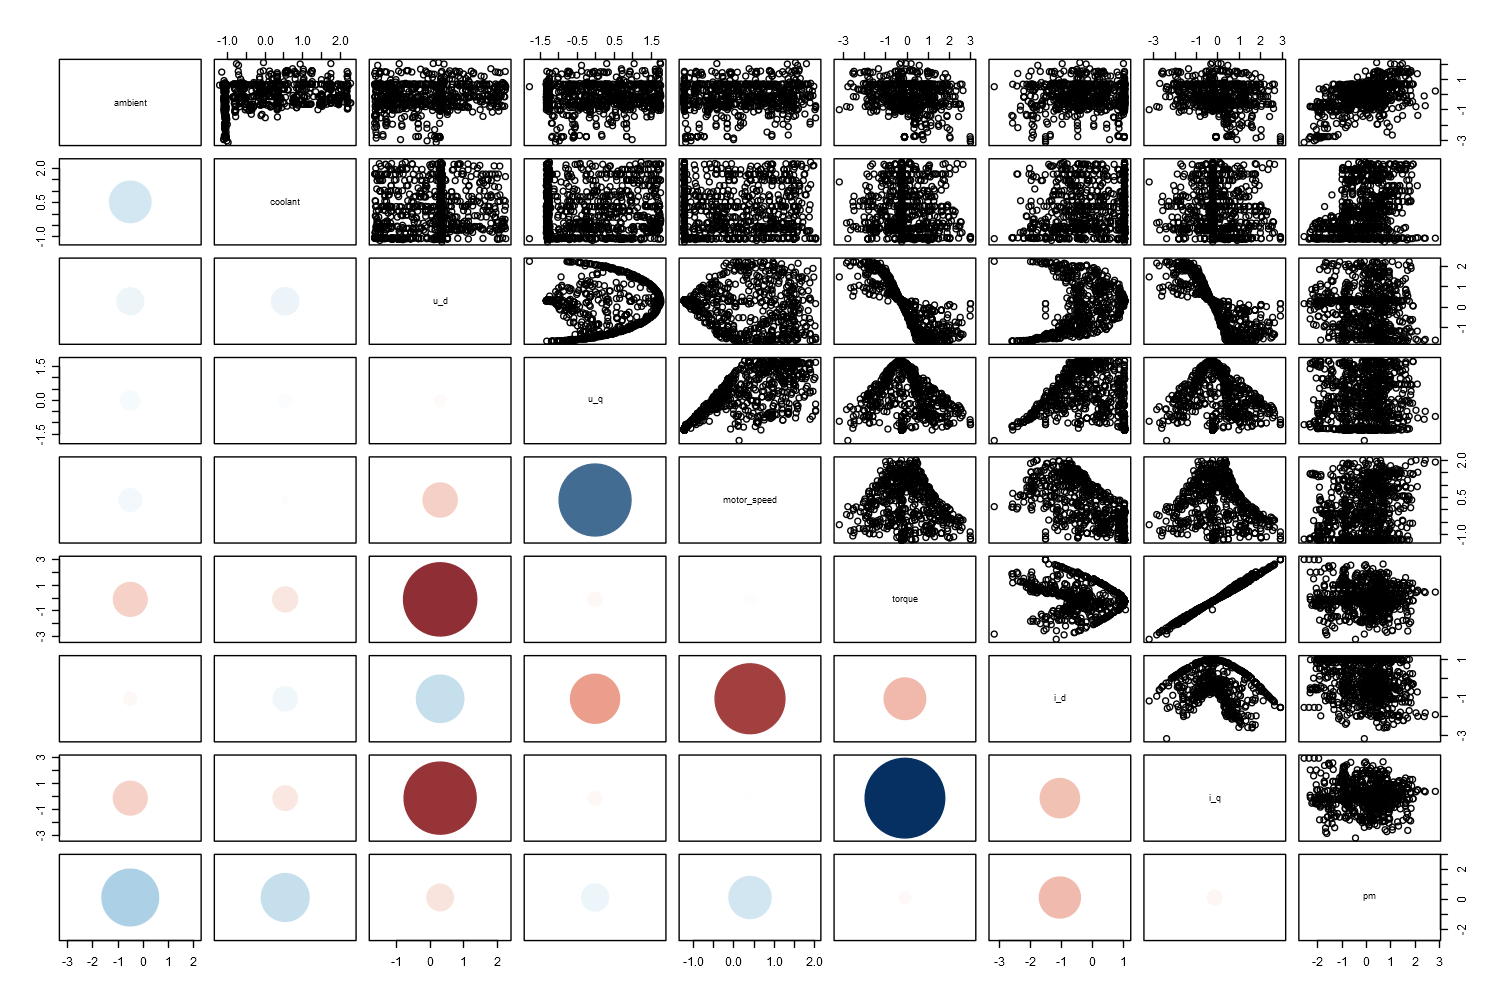

In [14]:
pairs(rotor_temp[sample.int(nrow(rotor_temp),1000),], lower.panel=panel.cor)

Above correlation matrix shows: 

- torque and i_q are highly correlated, as in we can see a linear relation between them.
- Similarly we can see linear relation between motor_speed and u_q.
- pm has a linear relation with ambient.
- u_d has a inverse linear relation with i_q and torque.


#### Scatter plot matrix

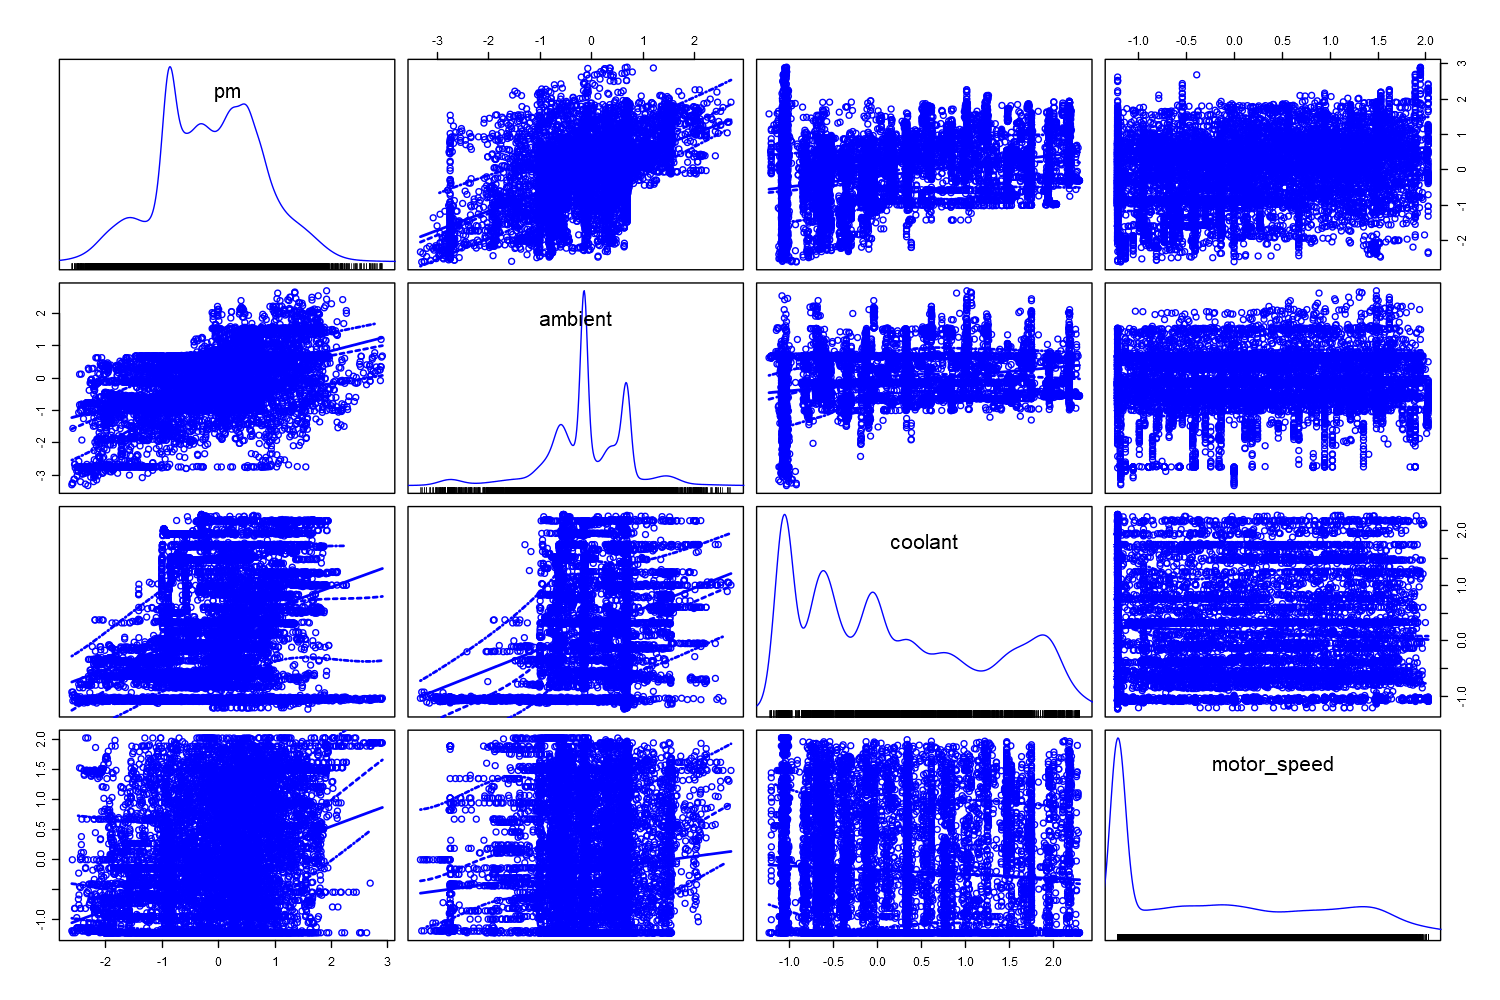

In [15]:
scatterplotMatrix(~pm+ambient+coolant+motor_speed,data=rotor_temp)

From above scatterplot we can observe that:

- Target variable has a linear relation with ambient variable.
- For other predcitors we can see a non-linear relation.
- Such information will be valuable when we chose models to perform prediction task. As there are models which are useful when there is non-linear relaiton between target and predcit variables.


## 3. Methodology<a class="anchor" id="sec_4"></a>

We are going to predict the temperature of rotor using **Linear Regression and Random Forest**. Before we can start with the prediction task, we need to aplit the data into training and testing data. We have already split the data in this step [Splitting data in training and testing dataset](#sec_13) above based on the profile_id 72 and 81. Training dataset will be used to fit the model, testing data will be predicted and analyzed.

Metric that we are going to use will be MSE (Mean Squared Error) for result comparison for test data.

#### 1. Linear Regression: 
After performing EDA, we now know what kind of data we have and relation amoung the variables. So, it's a start to build the first model. Model has metrics which will be helpful for rotor temperature prediction. Then we will be using stepwise selection, forward and backward, compare results and identify which attributes are more significant for prediction.

#### 2. Random Forrest:
Random Forest uses Ensemble Learning technique and based on bagging algorithm. It creates several trees of the data and finally combines the output of all the trees. RF also efficient to reduces overfitting problem in decision trees and improves the accuracy. It can be complex and might take more time for training, but it handles the non-linearity quite well compare to Linear Regression. It also does not required feature scaling becasue it uses rule based approach.


## 4. Model Development <a class="anchor" id="sec_5"></a>

#### 4.1 Linear Regression
We will start with Linear Regression, initially we are going to use of the variables and see how it performed based on few metrics.

#### 4.1.1 Linear Regression using all predictors

In [16]:
# fitting linear model
lm.fit1 <- lm(pm ~., data = training_data)
summary(lm.fit1)


Call:
lm(formula = pm ~ ., data = training_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.840 -0.458 -0.003  0.460  3.277 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.00856    0.00735    1.16   0.2445    
ambient      0.36617    0.00842   43.46   <2e-16 ***
coolant      0.32543    0.00832   39.10   <2e-16 ***
u_d         -0.17311    0.01613  -10.73   <2e-16 ***
u_q         -0.34809    0.01602  -21.73   <2e-16 ***
motor_speed  0.55801    0.02381   23.44   <2e-16 ***
torque      -0.32848    0.11797   -2.78   0.0054 ** 
i_d          0.03908    0.01690    2.31   0.0208 *  
i_q          0.24339    0.11091    2.19   0.0282 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.722 on 9643 degrees of freedom
Multiple R-squared:  0.492,	Adjusted R-squared:  0.491 
F-statistic: 1.17e+03 on 8 and 9643 DF,  p-value: <2e-16


We will be focusing on p values for analysis and variable selection. Other metrics such as r square and adjusted r square, we also look these metrics.
- From above model, we can see that ambient, coolant, u_d, u_q, motor_speed, torque all are significant variables, as they have small p-value.
- F statistic is very high, means we can reject the null Hypothesis (That there is no relation between predictor and target). It shows there is a relation between target and predictor variables.
- Adjusted R-squared and R-squared are at 49%, predictors have some significance in explaining the target variable.

#### Residual plots

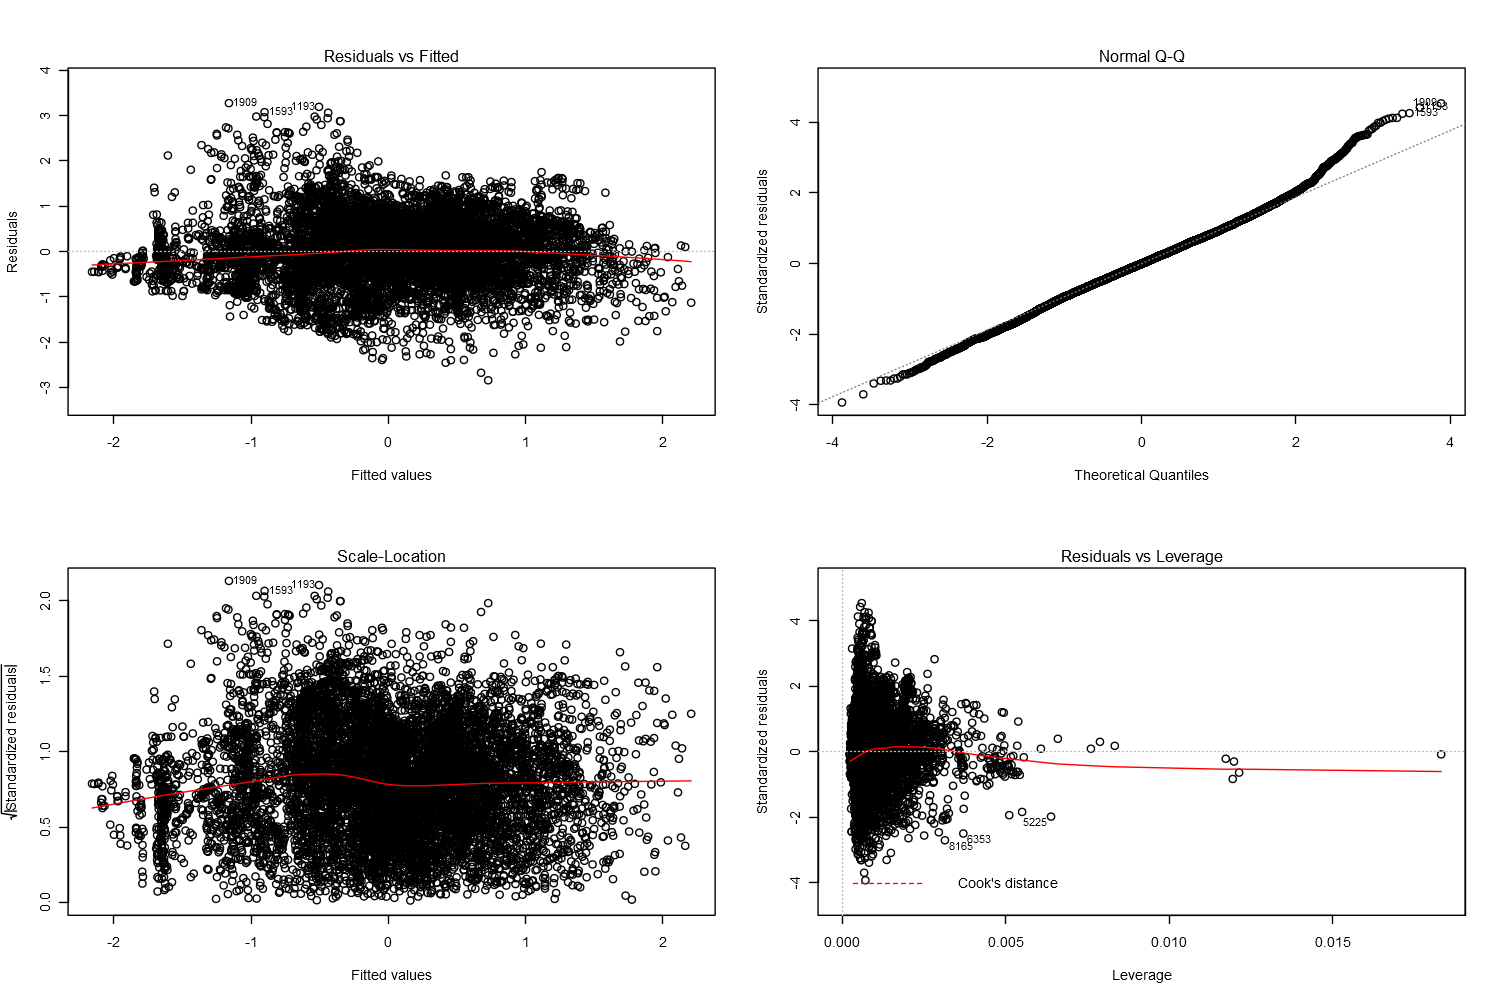

In [17]:
par(mfrow=c(2,2))
plot(lm.fit1)

- We can see outliers in Residual plot, maybe due to the skweness in the data. It also suggest that their is noo linear relation between predictors and target variable.
- From Q-Q plot, majority residuals are along the line.
- Scale-Location plot, residual are not evenly spreaded down the line.
- Residuall vs Leverage, all the points are within cook's distance.

Now let's run the model using transformation and let see if we can change the Adjusted R-squared and R-squared value.

#### 4.1.2 Linear Regression using transformation (log and sqrt) on input variable

In [18]:
# log transformations on coolant
lm.fit2 <- lm(pm ~ ambient+log10(coolant+1-min(coolant))+u_d+u_q+motor_speed+torque+i_d+i_q, data = training_data)
summary(lm.fit2)


Call:
lm(formula = pm ~ ambient + log10(coolant + 1 - min(coolant)) + 
    u_d + u_q + motor_speed + torque + i_d + i_q, data = training_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.883 -0.456 -0.003  0.456  3.299 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -0.48710    0.01566  -31.10   <2e-16 ***
ambient                            0.35592    0.00879   40.49   <2e-16 ***
log10(coolant + 1 - min(coolant))  1.61688    0.04524   35.74   <2e-16 ***
u_d                               -0.17453    0.01632  -10.69   <2e-16 ***
u_q                               -0.35227    0.01621  -21.74   <2e-16 ***
motor_speed                        0.57095    0.02409   23.70   <2e-16 ***
torque                            -0.27841    0.11928   -2.33   0.0196 *  
i_d                                0.05046    0.01709    2.95   0.0032 ** 
i_q                                0.19716    0.11214    1.76   0.0788 .  
---
Sig

In [19]:
# sqrt transformations on coolant
lm.fit2 <- lm(pm ~ ambient+sqrt(coolant+1-min(coolant))+u_d+u_q+motor_speed+torque+i_d+i_q, data = training_data)
summary(lm.fit2)


Call:
lm(formula = pm ~ ambient + sqrt(coolant + 1 - min(coolant)) + 
    u_d + u_q + motor_speed + torque + i_d + i_q, data = training_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.858 -0.458 -0.004  0.459  3.290 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -1.4262     0.0386  -36.93   <2e-16 ***
ambient                            0.3589     0.0086   41.74   <2e-16 ***
sqrt(coolant + 1 - min(coolant))   0.9832     0.0260   37.76   <2e-16 ***
u_d                               -0.1741     0.0162  -10.74   <2e-16 ***
u_q                               -0.3504     0.0161  -21.78   <2e-16 ***
motor_speed                        0.5648     0.0239   23.61   <2e-16 ***
torque                            -0.3047     0.1185   -2.57   0.0102 *  
i_d                                0.0446     0.0170    2.63   0.0087 ** 
i_q                                0.2217     0.1114    1.99   0.0466 *  
---
Signif. codes:

From above results we can see that except for torque and i_q predictors, all variables are significant after both log and sqrt transformation on coolant variable. Plus there is not much change in Adjusted R-squared and R-squared from previous section 4.1.1

#### 4.1.3 Linear Regression using transformation (log and sqrt) on input variable

In [20]:
cat("Using LOG TRANSFORMATION on target variable")
lm.fit3 <- lm(log10(pm+1-min(pm)) ~ ambient+coolant+u_d+u_q+motor_speed+torque+i_d+i_q, data = training_data)
summary(lm.fit3)
cat("\n---------------------------------------------------------------------------------------------------\n")
cat("Using SQRT TRANSFORMATION on target variable")
lm.fit3 <- lm(sqrt(pm+1-min(pm)) ~ ambient+coolant+u_d+u_q+motor_speed+torque+i_d+i_q, data = training_data)
summary(lm.fit3)

Using LOG TRANSFORMATION on target variable


Call:
lm(formula = log10(pm + 1 - min(pm)) ~ ambient + coolant + u_d + 
    u_q + motor_speed + torque + i_d + i_q, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4659 -0.0538  0.0081  0.0617  0.3829 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.53763    0.00101  530.53  < 2e-16 ***
ambient      0.05655    0.00116   48.71  < 2e-16 ***
coolant      0.04170    0.00115   36.36  < 2e-16 ***
u_d         -0.02824    0.00222  -12.70  < 2e-16 ***
u_q         -0.04212    0.00221  -19.08  < 2e-16 ***
motor_speed  0.06843    0.00328   20.86  < 2e-16 ***
torque      -0.07159    0.01626   -4.40  1.1e-05 ***
i_d          0.00427    0.00233    1.83   0.0666 .  
i_q          0.05528    0.01528    3.62   0.0003 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0995 on 9643 degrees of freedom
Multiple R-squared:  0.496,	Adjusted R-squared:  0.495 
F-statistic: 1.18e+03 on 8 and 9643 DF,


---------------------------------------------------------------------------------------------------
Using SQRT TRANSFORMATION on target variable


Call:
lm(formula = sqrt(pm + 1 - min(pm)) ~ ambient + coolant + u_d + 
    u_q + motor_speed + torque + i_d + i_q, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8512 -0.1202  0.0087  0.1263  0.8397 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.88008    0.00203  927.21  < 2e-16 ***
ambient      0.10789    0.00232   46.44  < 2e-16 ***
coolant      0.08776    0.00229   38.24  < 2e-16 ***
u_d         -0.05181    0.00445  -11.64  < 2e-16 ***
u_q         -0.09068    0.00442  -20.53  < 2e-16 ***
motor_speed  0.14630    0.00656   22.29  < 2e-16 ***
torque      -0.11466    0.03253   -3.52  0.00043 ***
i_d          0.00927    0.00466    1.99  0.04680 *  
i_q          0.08701    0.03058    2.85  0.00445 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.199 on 9643 degrees of freedom
Multiple R-squared:  0.498,	Adjusted R-squared:  0.498 
F-statistic: 1.2e+03 on 8 and 9643 DF,  p

- From above results we can see that except for i_d predictor, all variables are significant after both log transformation on target variable (pm). 
- Plus there is slight change in Adjusted R-squared and R-squared from previous sections 4.1.1 and 4.1.2, increased to 49.5% (log) and 49.8% (sqrt) previously from 49.1% and 48%.

#### 4.1.4 Correlation and Interaction

In [21]:
lm.fit4 <- lm(log(pm+1-min(pm)) ~ ambient+coolant+u_d+u_q+motor_speed+torque+i_d+i_q+
              motor_speed:u_q+torque:i_q+torque:u_d+motor_speed:i_d, data = training_data)
summary(lm.fit4)


Call:
lm(formula = log(pm + 1 - min(pm)) ~ ambient + coolant + u_d + 
    u_q + motor_speed + torque + i_d + i_q + motor_speed:u_q + 
    torque:i_q + torque:u_d + motor_speed:i_d, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4104 -0.1113  0.0158  0.1309  0.8341 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.57995    0.01557  101.49  < 2e-16 ***
ambient          0.12051    0.00263   45.85  < 2e-16 ***
coolant          0.07798    0.00266   29.32  < 2e-16 ***
u_d             -0.08884    0.00529  -16.79  < 2e-16 ***
u_q             -0.84821    0.02889  -29.36  < 2e-16 ***
motor_speed      1.15594    0.03804   30.38  < 2e-16 ***
torque          -0.22438    0.03717   -6.04  1.6e-09 ***
i_d              0.54437    0.02099   25.94  < 2e-16 ***
i_q              0.22840    0.03475    6.57  5.2e-11 ***
u_q:motor_speed -0.02472    0.00347   -7.13  1.0e-12 ***
torque:i_q      -0.02054    0.00341   -6.03  1.7e-09 ***
u_d

- After using Correlation and Interaction of the predictor variable 
- we can clearly observe change in the Adjusted R-squared and R-squared compare to all previous sections.
- Remember, we are using sqrt transformaton on target variable.

#### 4.1.5 Forward and Backward Step Selection

Now we will perfom step selection to select significant variables. So far from above results (based on p-value, F-Statistics, Adjusted R-squared and R-squared) we can say all the inputs are significant. But just rule out any possibility we will perform step selection both forward and backward.

In [22]:
lm1 <- step(lm.fit4, direction= "forward") # forward step selection
summary(lm1)

Start:  AIC=-29191
log(pm + 1 - min(pm)) ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + i_q + motor_speed:u_q + torque:i_q + torque:u_d + 
    motor_speed:i_d




Call:
lm(formula = log(pm + 1 - min(pm)) ~ ambient + coolant + u_d + 
    u_q + motor_speed + torque + i_d + i_q + motor_speed:u_q + 
    torque:i_q + torque:u_d + motor_speed:i_d, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4104 -0.1113  0.0158  0.1309  0.8341 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.57995    0.01557  101.49  < 2e-16 ***
ambient          0.12051    0.00263   45.85  < 2e-16 ***
coolant          0.07798    0.00266   29.32  < 2e-16 ***
u_d             -0.08884    0.00529  -16.79  < 2e-16 ***
u_q             -0.84821    0.02889  -29.36  < 2e-16 ***
motor_speed      1.15594    0.03804   30.38  < 2e-16 ***
torque          -0.22438    0.03717   -6.04  1.6e-09 ***
i_d              0.54437    0.02099   25.94  < 2e-16 ***
i_q              0.22840    0.03475    6.57  5.2e-11 ***
u_q:motor_speed -0.02472    0.00347   -7.13  1.0e-12 ***
torque:i_q      -0.02054    0.00341   -6.03  1.7e-09 ***
u_d

In [23]:
lm2 <- step(lm.fit4, direction= "backward") # backward step selection
summary(lm2)

Start:  AIC=-29191
log(pm + 1 - min(pm)) ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + i_q + motor_speed:u_q + torque:i_q + torque:u_d + 
    motor_speed:i_d

                  Df Sum of Sq RSS    AIC
<none>                         468 -29191
- torque:i_q       1       1.8 469 -29157
- u_q:motor_speed  1       2.5 470 -29142
- u_d:torque       1       4.7 472 -29097
- motor_speed:i_d  1      30.4 498 -28585
- coolant          1      41.7 509 -28368
- ambient          1     102.0 570 -27289



Call:
lm(formula = log(pm + 1 - min(pm)) ~ ambient + coolant + u_d + 
    u_q + motor_speed + torque + i_d + i_q + motor_speed:u_q + 
    torque:i_q + torque:u_d + motor_speed:i_d, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4104 -0.1113  0.0158  0.1309  0.8341 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.57995    0.01557  101.49  < 2e-16 ***
ambient          0.12051    0.00263   45.85  < 2e-16 ***
coolant          0.07798    0.00266   29.32  < 2e-16 ***
u_d             -0.08884    0.00529  -16.79  < 2e-16 ***
u_q             -0.84821    0.02889  -29.36  < 2e-16 ***
motor_speed      1.15594    0.03804   30.38  < 2e-16 ***
torque          -0.22438    0.03717   -6.04  1.6e-09 ***
i_d              0.54437    0.02099   25.94  < 2e-16 ***
i_q              0.22840    0.03475    6.57  5.2e-11 ***
u_q:motor_speed -0.02472    0.00347   -7.13  1.0e-12 ***
torque:i_q      -0.02054    0.00341   -6.03  1.7e-09 ***
u_d

After performing both forward and backward step selection, it's now very clear that all the inputs and their correlation interaction are significant for the prediction.

#### 4.1.6 RMSE for Training Data

In [24]:
mse <- mean((training_data$pm - exp(lm1$fitted.values))^2) # Mean Sqaured Error
cat("The RMSE for Training Data for Linear Regression is:",sqrt(mse))

The RMSE for Training Data for Linear Regression is: 3.708

#### 4.1.7 MSE for Test Data

In [25]:
pred  <- predict(lm.fit4, testing_data) # Predicting the rotor temperature for test data
avg.mse  <- mean((pred-testing_data$pm)^2) # Calculating MSE for Test data
cat("The MSE for Testing Data for Linear Regression is:",avg.mse)

The MSE for Testing Data for Linear Regression is: 2.814

#### 4.2 Random Forrest

For our second model, we are going to use Random Forrest. As we saw in previous model, all predcitors were significant with low p-value, and gave low RMSE and MSE on training data and testing data respectively. It will be interesting to know if this model can perform better than previous one.

In [26]:
rf.fit <- randomForest(pm~., data = training_data)
rf.fit


Call:
 randomForest(formula = pm ~ ., data = training_data) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 0.1428
                    % Var explained: 86.08

Above result gives us details that RF was generated by 500 trees. We have a very low Mean of squared residuals and 85.96% variance explained by the model which is a good sign. Now we will perform the feature selection using RF.

,IncNodePurity
ambient,2190.8
coolant,2279.3
u_d,1055.4
u_q,777.4
motor_speed,1108.6
torque,704.4
i_d,945.5
i_q,671.4


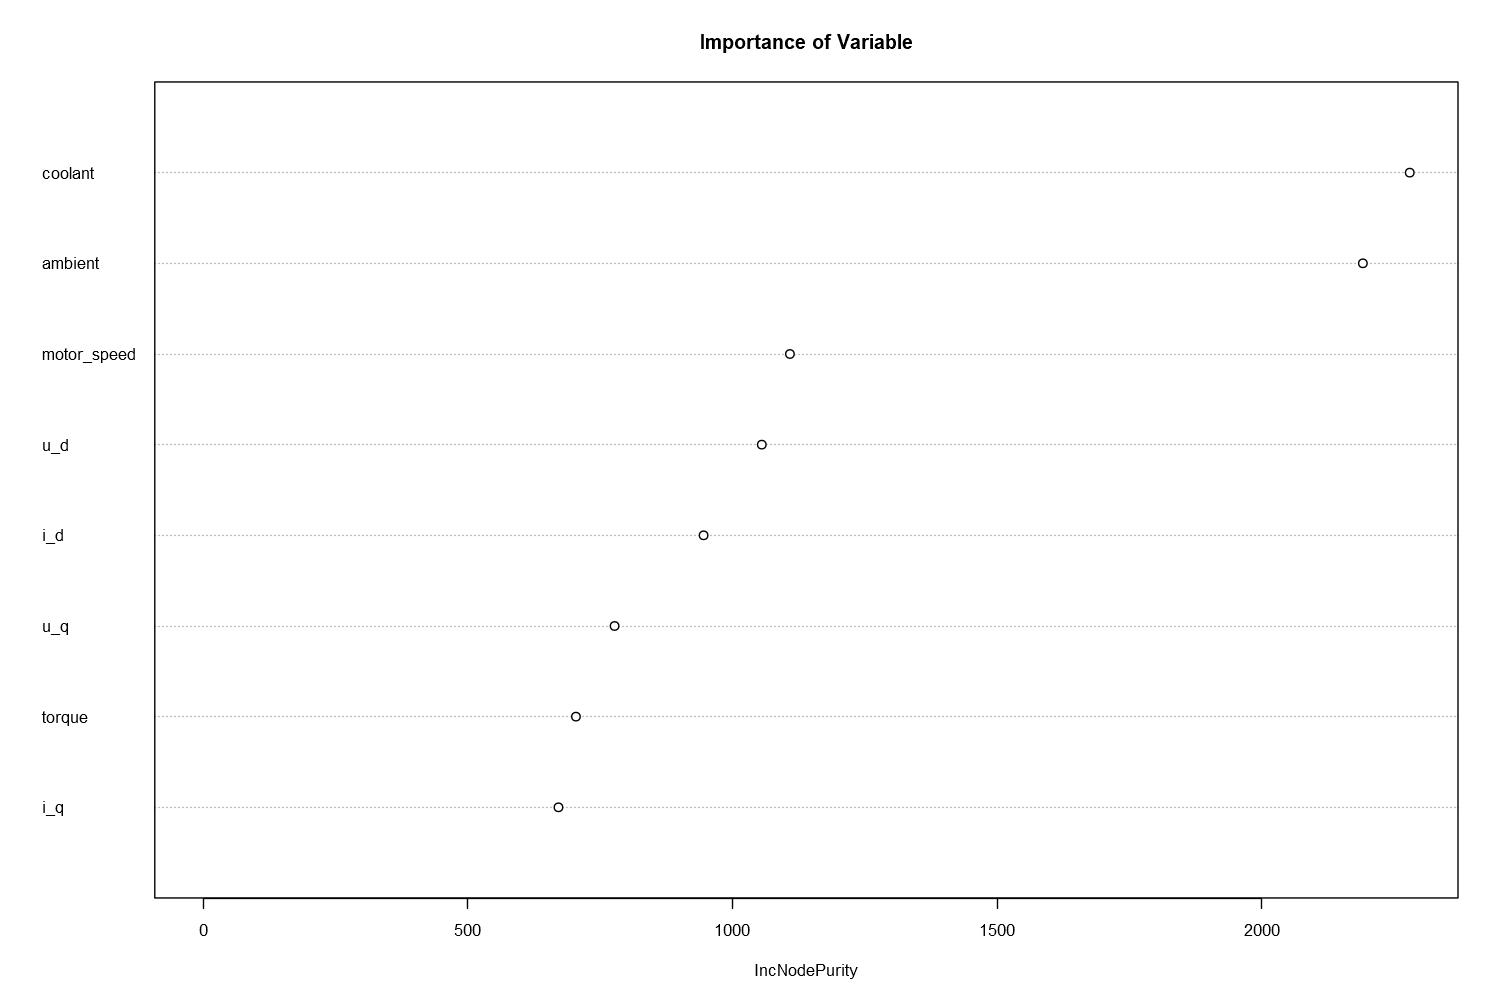

In [27]:
(VI_F=importance(rf.fit)) # node purity for each variable
varImpPlot(rf.fit, scale =T, main = "Importance of Variable")

In [28]:
set.seed(40)
# find minimum number of trees to get lowest MSE
x <- which.min(rf.fit$mse)

cat("We got", x,"as the optimal number of trees, now going forward we will use this many trees and analyze if it improves the model performance any further.")

rf.fit2 <- randomForest(pm ~ ambient+coolant+u_d+u_q+motor_speed+torque+i_d+i_q+
                        motor_speed:u_q+torque:i_q+torque:u_d+motor_speed:i_d, data = training_data, ntree = x)
rf.fit2

We got 428 as the optimal number of trees, now going forward we will use this many trees and analyze if it improves the model performance any further.


Call:
 randomForest(formula = pm ~ ambient + coolant + u_d + u_q + motor_speed +      torque + i_d + i_q + motor_speed:u_q + torque:i_q + torque:u_d +      motor_speed:i_d, data = training_data, ntree = x) 
               Type of random forest: regression
                     Number of trees: 428
No. of variables tried at each split: 2

          Mean of squared residuals: 0.1436
                    % Var explained: 86

In [29]:
# Calculating RMSE for training data
mse = mean((training_data$pm - rf.fit2$predicted)^2)
cat("RMSE of RF Model on Training data is", sqrt(mse))

RMSE of RF Model on Training data is 0.3789

In [30]:
# Making Prediction on testing data and calculating it'd MSE
rf.pred <- predict(rf.fit2, testing_data)
mse = mean((rf.pred - testing_data$pm)^2)
cat("MSE of RF Model on Testing data is", mse)

MSE of RF Model on Testing data is 0.617

In [31]:
# MSE and Adjusted R Square of Random Forest Model
cat("MSE of Random Forest Model", mean(rf.fit2$mse))
cat("\nAdjusted R Square of Random Forest Model", mean(rf.fit2$rsq))

MSE of Random Forest Model 0.1507
Adjusted R Square of Random Forest Model 0.853

From above three cells, we can see the Random Forest Model gave us low RMSE for training data, low MSE for testing data and low MSE and high Adjusted R Square for Random Forest model itself.

## 5. Results and discussion <a class="anchor" id="sec_6"></a>

I have used two different model Linear Regression and Random Forest for prediction. We all are aware that no model is good but some are useful. Metrics such as MSE and adjusted r square we have compare the performance of the two models. Initially we performed EDA both visual and non-visual which gave us better insights into the data. Then used some tranformation and correlation technique for better clarity of predictor variable.

We started with Linear regression which simple and easy to interperate, and saw different version by using log and sqrt transformation on predictor and then target variable. The we performed forward and backward selection of features, and finally a correlation and interaction technique. All the models suggested that all predictor variable are significant with high F-Statistics and low p-value. Then we made predction on test data and calculated the MSE for that, which was low plus the RMSE of training data was also low. For linear regression to work better, it's good to have a linear relation between input and traget variables. But we did have some non-linearity.

Then we moved to more complex model Random Forest, which is known to avoid overfitting because it uses rule based approach. RF gave us low MSE and high adjusted r square. We also saw feature selection and RF model also suggested that all predictor variables are significant for the analysis. RF gave low MSE and high percentage of variance explanation. As we saw in EDA a non-linearity between input and target variable, RF is the best option in such cases. Most importantly, RF model is robust to outliers and handles them automatically and very less impacted by noise, that is why it is more stable.

Variables that were important for the analysis and predcition of rotor temperature for linear regression were ambient, coolant, u_d, u_q, motor_speed, torque, i_d, i_q plus when we add the correlation and interaction it improves further. All these features where selected based on the p-values, as all of them had p-vlaue less than 0.005

Variables that were important for the analysis and predcition of rotor temperature for random forest were ambient, coolant, u_d, u_q, motor_speed, torque, i_d, i_q. We decided these features based on the node purity, importance of variable.

If we compare both the models, both of them have done a good job, but Random forest has performed slightly better than linear regression model both in terms of MSE and adjusted r square. Further RF has low RMSE and MSE for training data and testing data respectively compare to linear model results.

## 6. Conclusion<a class="anchor" id="sec_7"></a>

For this project we used two models, Linear Regression and Random Forest to predict the rotor temperature. To built these models we saw different types of techniques and based on some metric we developed the model to predict temperature of rotor. We choose significant variable based on p-values and node purity, and we saw that all variable are of significance. To make sure models are compared without any bias we used MSE as a metric. Based on MSE we got random forest with lowest MSE. We saw non-linear relation between predictor and target and for future studies we can use more complex models but the results we got from above two models were good enough. If we have more data we can make for inference in future.

## 7. References <a class="anchor" id="sec_8"></a>

Tutorial from week 2 to week 6 and class notes<br>
https://www.listendata.com/2014/11/random-forest-with-r.html<br>
https://statsandr.com/blog/descriptive-statistics-in-r/<br>
https://rpubs.com/Mentors_Ubiqum/removing_outliers<br>
https://feliperego.github.io/blog/2015/10/23/Interpreting-Model-Output-In-R#:~:text=The%20Residual%20Standard%20Error%20is,approximately%2015.3795867%20feet%2C%20on%20average.